In [ ]:
## Scrap this Code Just Dummy Data Plot

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue
    azista_color = 'red'    # A distinct red
    
    # You can also use 'tab:blue', 'tab:red', etc., from matplotlib's default color cycle
    # vaisala_color = 'tab:blue'
    # azista_color = 'tab:red'

    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    #fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original Code
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        
        # Plot Azista data with consistent color and linestyle
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Vaisala RS41-SG vs Azista ATMS-3710 )', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78,
        random_noise_scale=1.0 # Default noise scale
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics and noise)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_noise_scale=1.2 # Slightly more overall noise for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

Generating dummy radiosonde data...
Plotting radiosonde data...


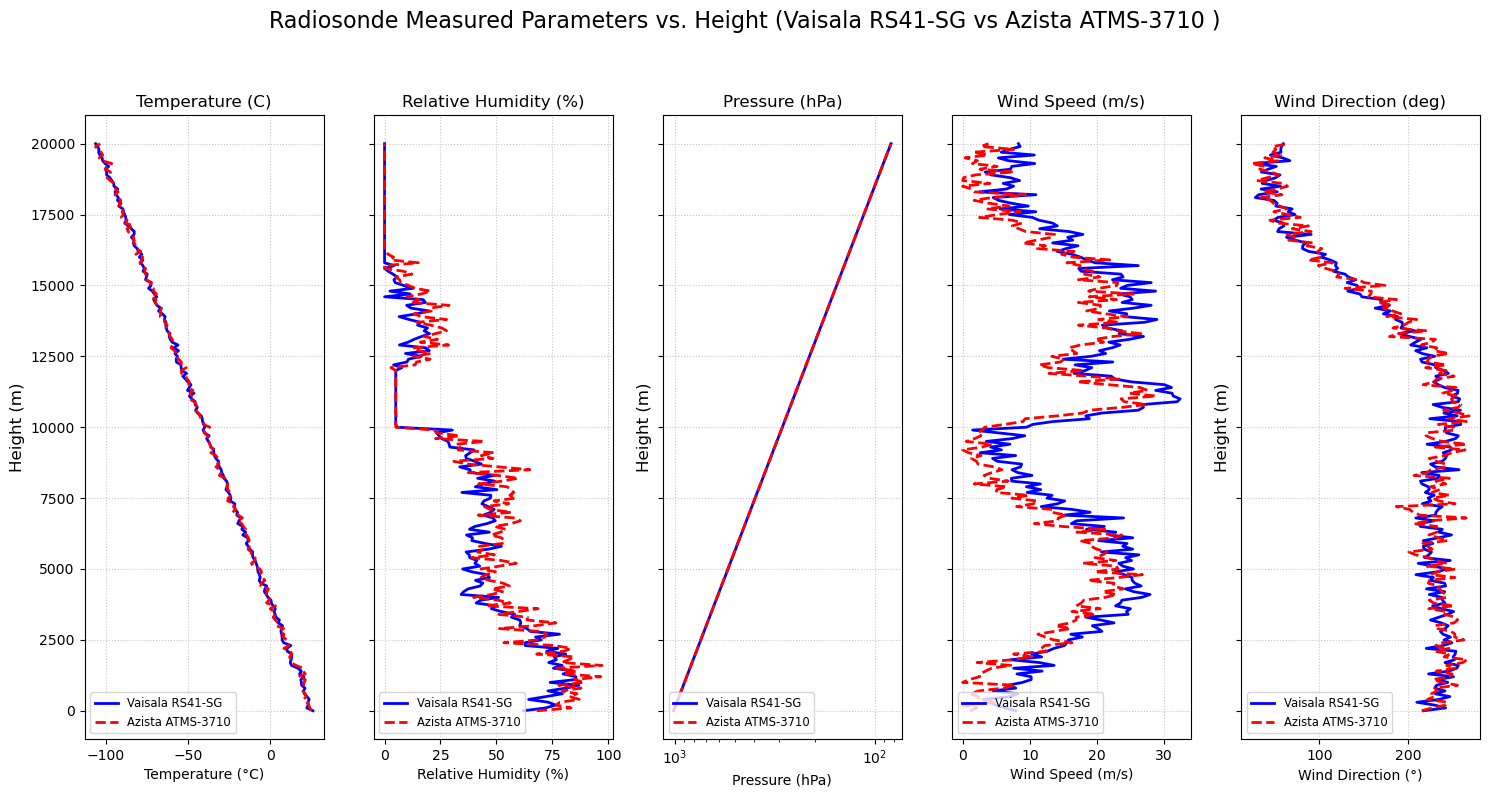

Plotting complete.


In [7]:
## Refind and Code Refactored for Plotting All Variables in a single plot. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue
    azista_color = 'red'    # A distinct red
    
    # You can also use 'tab:blue', 'tab:red', etc., from matplotlib's default color cycle
    # vaisala_color = 'tab:blue'
    # azista_color = 'tab:red'

    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    #fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original Code
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        
        # Plot Azista data with consistent color and linestyle
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Vaisala RS41-SG vs Azista ATMS-3710 )', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78,
        random_noise_scale=1.0 # Default noise scale
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics and noise)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_noise_scale=1.2 # Slightly more overall noise for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

Vaisala data file not found at: vaisala_data.csv
Azista data file not found at: azista_data.csv

Not all real data loaded. Generating and plotting DUMMY DATA for demonstration.


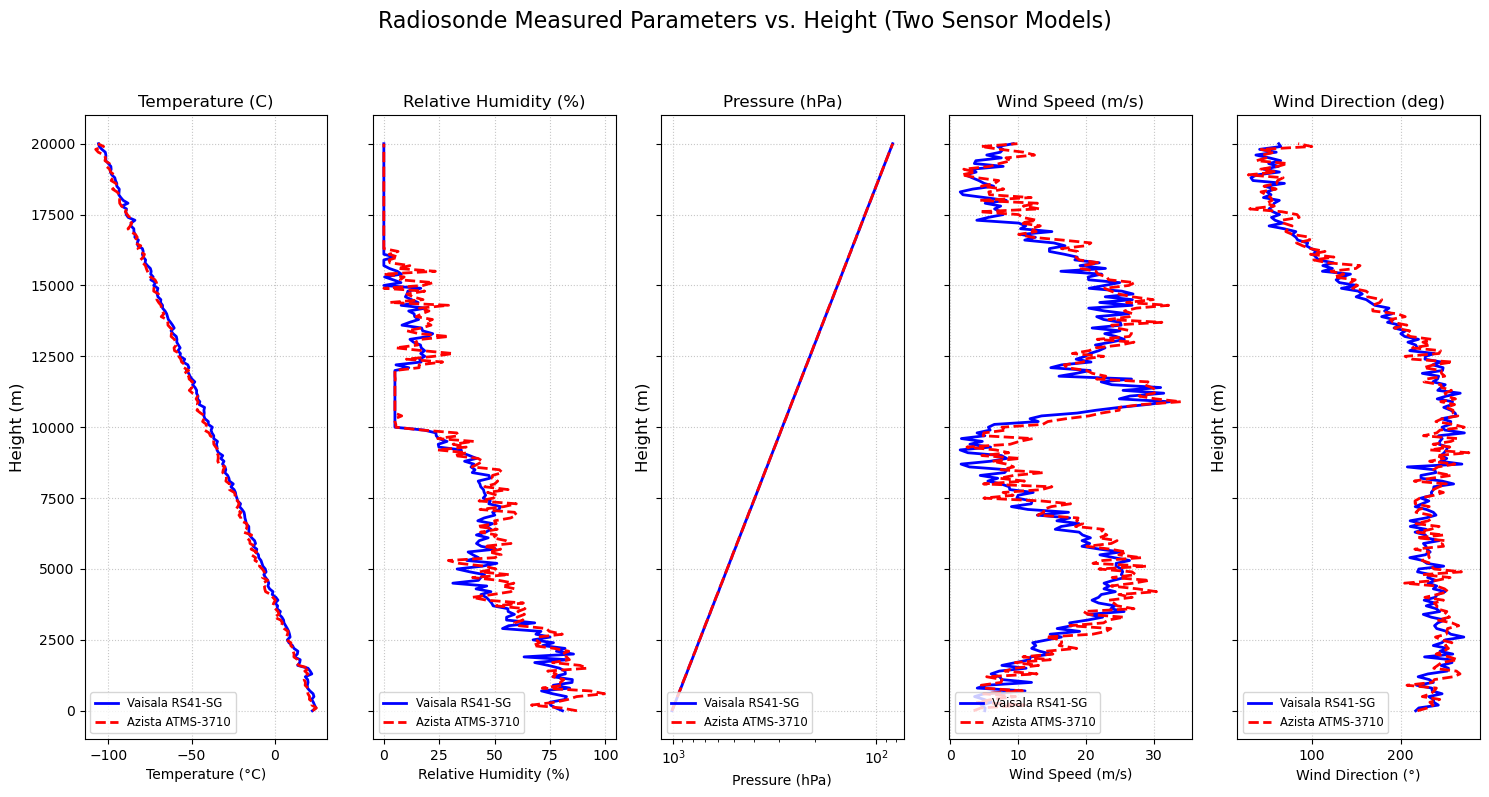

Plotting complete.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os # For checking if files exist

# --- UTILITY FUNCTION: GENERATE DUMMY DATA (for demonstration/testing if no real data is provided) ---
def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.
    This function is primarily for demonstration purposes.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

# --- CORE PLOTTING FUNCTION ---
def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.

    Expected DataFrame Columns:
    - 'Height (m)'
    - 'Temperature (C)'
    - 'Relative Humidity (%)'
    - 'Pressure (hPa)'
    - 'Wind Speed (m/s)'
    - 'Wind Direction (deg)'
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue for Vaisala
    azista_color = 'red'    # A distinct red for Azista
    
    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    # fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original line of script un comment this line if necessary
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        # Ensure the column exists in the DataFrame before plotting
        if col_name in df_vaisala.columns:
            ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                    label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        else:
            print(f"Warning: Column '{col_name}' not found in Vaisala data. Skipping plot for this variable.")
        
        # Plot Azista data with consistent color and linestyle
        if col_name in df_azista.columns:
            ax.plot(df_azista[col_name], df_azista['Height (m)'],
                    label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        else:
            print(f"Warning: Column '{col_name}' not found in Azista data. Skipping plot for this variable.")

        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Two Sensor Models)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    # --- YOUR DATA SOURCE CONFIGURATION STARTS HERE ---

    # 1. Specify the FULL PATH to your real data files.
    #    Example: 'C:/Users/YourUser/Documents/radiosonde_data/vaisala_launch1.csv'
    #    Example for macOS/Linux: '/Users/YourUser/data/azista_launch_20230501.xlsx'

    # IMPORTANT: REPLACE THESE WITH YOUR ACTUAL FILE PATHS
    vaisala_data_path = 'vaisala_data.csv'  # <--- MODIFY THIS LINE
    azista_data_path = 'azista_data.csv'    # <--- MODIFY THIS LINE

    # 2. Load your data into pandas DataFrames.
    #    The plotting function expects your DataFrames to have specific column names:
    #    'Height (m)', 'Temperature (C)', 'Relative Humidity (%)',
    #    'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (deg)'

    df_vaisala_real = None
    df_azista_real = None

    try:
        if os.path.exists(vaisala_data_path):
            print(f"Attempting to load Vaisala data from: {vaisala_data_path}")
            # Use pd.read_csv for CSV files
            df_vaisala_real = pd.read_csv(vaisala_data_path)
            # Use pd.read_excel for Excel files (requires openpyxl: pip install openpyxl)
            # df_vaisala_real = pd.read_excel(vaisala_data_path)
        else:
            print(f"Vaisala data file not found at: {vaisala_data_path}")

        if os.path.exists(azista_data_path):
            print(f"Attempting to load Azista data from: {azista_data_path}")
            df_azista_real = pd.read_csv(azista_data_path)
            # df_azista_real = pd.read_excel(azista_data_path)
        else:
            print(f"Azista data file not found at: {azista_data_path}")

        # --- 3. RENAME COLUMNS IF NECESSARY ---
        # If your actual data columns have different names (e.g., 'ALT', 'TEMP', 'RH'),
        # you MUST rename them to match the expected names for the plotting function.
        # Uncomment and modify the following lines if your column names differ.

        # Example for Vaisala data renaming:
        # df_vaisala_real = df_vaisala_real.rename(columns={
        #     'Altitude_Meters': 'Height (m)',
        #     'Air_Temp_C': 'Temperature (C)',
        #     'RH_Percent': 'Relative Humidity (%)',
        #     'Press_hPa': 'Pressure (hPa)',
        #     'Wind_Speed_MPS': 'Wind Speed (m/s)',
        #     'Wind_Dir_Deg': 'Wind Direction (deg)'
        # })

        # Example for Azista data renaming:
        # df_azista_real = df_azista_real.rename(columns={
        #     'Alt(m)': 'Height (m)',
        #     'T(C)': 'Temperature (C)',
        #     'Humidity(%)': 'Relative Humidity (%)',
        #     'P(hPa)': 'Pressure (hPa)',
        #     'Ws(m/s)': 'Wind Speed (m/s)',
        #     'Wd(deg)': 'Wind Direction (deg)'
        # })

    except Exception as e:
        print(f"\nAn error occurred while loading real data: {e}")
        print("Please ensure the file paths are correct and the files are accessible.")
        print("Falling back to generating and plotting DUMMY DATA for demonstration.")
        df_vaisala_real = None # Ensure they are None so dummy data is used below
        df_azista_real = None


    # --- PLOT THE DATA ---
    if df_vaisala_real is not None and df_azista_real is not None:
        print("\nPlotting REAL radiosonde data...")
        plot_radiosonde_data(df_vaisala_real, df_azista_real)
    else:
        print("\nNot all real data loaded. Generating and plotting DUMMY DATA for demonstration.")
        vaisala_dummy = generate_radiosonde_dummy_data(
            model_name='Vaisala RS41-SG', base_temp_c=25.2, base_pressure_hpa=1012.8, base_rh_percent=78, random_noise_scale=1.0)
        azista_dummy = generate_radiosonde_dummy_data(
            model_name='Azista ATMS-3710', base_temp_c=24.8, base_pressure_hpa=1013.5, base_rh_percent=82, random_noise_scale=1.2)
        plot_radiosonde_data(vaisala_dummy, azista_dummy)

    print("Plotting complete.")

In [10]:
import pandas as pd
import re

def load_radiosonde_edt(filepath):
    """
    Loads radiosonde data from a .edt ASCII file into a pandas DataFrame.

    Args:
        filepath (str): The path to the .edt ASCII file.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The radiosonde data.
            - dict: A dictionary containing parsed header metadata.
    """
    header_lines = []
    data_lines = []
    column_names = []
    units_map = {}
    data_start_line = -1

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Identify header, column names, and data start
    for i, line in enumerate(lines):
        if "Time" in line and "Hght" in line and "Press" in line:
            # This is likely the column names line
            column_names = re.split(r'\s{2,}', line.strip())
            # Clean up empty strings from split
            column_names = [col for col in column_names if col]
            data_start_line = i + 3 # Data starts 3 lines after column names line (1 for units, 2 for empty line)
            break
        else:
            header_lines.append(line.strip())

    if not column_names or data_start_line == -1:
        raise ValueError("Could not determine column names or data start in the file.")

    # Parse units from the line after column names
    units_line = lines[data_start_line - 2].strip()
    units_split = re.split(r'\s{2,}', units_line)
    units_split = [unit for unit in units_split if unit] # Clean up empty strings

    # Map column names to units, handling the 'Time' columns
    if 'min s' in column_names[0]: # Handle the "min s" combined column
        units_map[column_names[0].split()[0]] = units_split[0] # 'min'
        units_map[column_names[0].split()[1]] = units_split[1] # 's'
        # Adjust for the split 'Time' column in units_split
        for j, col_name in enumerate(column_names[1:]):
            units_map[col_name] = units_split[j+2]
    else: # If 'Time' is already split into two columns
        for j, col_name in enumerate(column_names):
            if j < len(units_split): # Ensure we don't go out of bounds
                units_map[col_name] = units_split[j]


    # Extract data lines
    data_lines = lines[data_start_line:]

    # Parse header metadata
    metadata = {}
    for h_line in header_lines:
        if ':' in h_line:
            key, value = h_line.split(':', 1)
            metadata[key.strip()] = value.strip()

    # Load data into DataFrame
    # Need to handle the 'Time' column which is 'min s' and needs to be combined or split
    # For now, let's treat it as two separate columns as it appears in the data
    df_columns = ['Time_min', 'Time_s'] + column_names[1:] # Adjust for split Time

    # Read data using pandas, skipping header and units lines
    # We specify widths for better parsing given the fixed-width-like format
    # This requires more careful definition if widths aren't consistent.
    # A simpler approach for space-separated is read_csv with sep=r'\s+'

    # Re-read with pandas for robust parsing, specifying appropriate skipping
    # We need to find the exact skip rows dynamically
    skip_rows_count = data_start_line

    # Prepare data for DataFrame, splitting 'Time min s'
    processed_data = []
    for line in data_lines:
        parts = re.split(r'\s+', line.strip())
        if len(parts) > 2: # Ensure there's enough data
            # Combine 'min' and 's' into one time value (e.g., total seconds) or keep separate
            # For simplicity, we'll keep them as two columns 'Time_min' and 'Time_s'
            row_data = [float(parts[0]), float(parts[1])] + [float(p) for p in parts[2:]]
            processed_data.append(row_data)

    df = pd.DataFrame(processed_data, columns=df_columns)

    return df, metadata, units_map


if __name__ == "__main__":
    file_path = "D:\\Data\\ekam-radiosonde-data\\Data for Analysis\\Vaisala Data along with AZISTA sonde-reg\\SN_2024_ekamsat2407080557.EDT" # Replace with your actual file path

    # Create a dummy .edt file for demonstration
    dummy_data = """Station         : SN_2024_ekamsat
Location      : 11.2567 72.5357 9 m
Launch time   : 2024 07 08 at 05 57 UTC
RS type       : RS41-SG
RS number     : W1857420

    Time     Hght   Press   Temp   Hum     Td    MixR     DD    FF Latitude  Longitude
    min s     gpm     hPa   degC     %   degC    g/kg    deg   m/s     deg       deg

    0  0      5.09 1005.08  29.40  75.0  24.52   19.60    258  11.0   11.2567    72.5357
    0  1      9.55 1004.29  30.32  73.9  25.17   20.42    258   6.5   11.2564    72.5362
    0  2     11.39 1004.28  30.26  73.9  25.11   20.35    257   5.1   11.2563    72.5364
    0  3     12.87 1004.27  30.26  74.1  25.14   20.39    256   4.9   11.2563    72.5364
    0  4     15.68 1004.17  30.19  74.4  25.16   20.42    256   5.2   11.2563    72.5364
    0  5     20.89 1003.37  30.09  74.6  25.10   20.37    256   5.7   11.2563    72.5365
    0  6     27.79 1002.44  29.99  74.4  24.96   20.21    255   6.1   11.2563    72.5365
    0  7     34.91 1001.51  29.88  74.0  24.75   19.97    255   6.5   11.2563    72.5366
    0  8     41.08 1001.05  29.72  73.9  24.59   19.77    255   6.8   11.2563    72.5367
    0  9     46.55 1000.53  29.59  74.0  24.48   19.64    255   7.2   11.2564    72.5368
    0 10     51.87  999.84  29.53  73.8  24.38   19.53    254   7.7   11.2564    72.5369
    0 11     57.20  999.25  29.48  73.8  24.33   19.48    254   8.1   11.2564    72.5370
    0 12     62.66  998.74  29.43  74.0  24.33   19.49    254   8.5   11.2564    72.5371
    0 13     68.25  998.01  29.37  74.3  24.34   19.52    253   8.9   11.2564    72.5372
"""
    with open(file_path, "w") as f:
        f.write(dummy_data)


    try:
        df, metadata, units = load_radiosonde_edt(file_path)

        print("--- Radiosonde Data Loaded Successfully ---")
        print("\nMetadata:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")

        print("\nUnits:")
        for col, unit in units.items():
            print(f"  {col}: {unit}")

        print("\nFirst 5 rows of DataFrame:")
        print(df.head())

        print("\nDataFrame Info:")
        df.info()

        print("\nBasic Statistics for 'Temp' and 'Hght' columns:")
        print(df[['Temp', 'Hght']].describe())

        # Example of further analysis:
        # Calculate total time in seconds
        df['Total_Time_s'] = df['Time_min'] * 60 + df['Time_s']

        # Plot temperature vs. height (requires matplotlib)
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.plot(df['Temp'], df['Hght'])
            plt.xlabel(f"Temperature ({units['Temp']})")
            plt.ylabel(f"Height ({units['Hght']})")
            plt.title("Radiosonde: Temperature vs. Height Profile")
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.plot(df['Press'], df['Hght'])
            plt.xlabel(f"Pressure ({units['Press']})")
            plt.ylabel(f"Height ({units['Hght']})")
            plt.title("Radiosonde: Pressure vs. Height Profile")
            plt.grid(True)
            plt.gca().invert_xaxis() # Pressure decreases with height
            plt.show()


        except ImportError:
            print("\nMatplotlib not installed. Skipping plotting examples.")
            print("To install: pip install matplotlib")

    except ValueError as e:
        print(f"Error loading file: {e}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")

Error loading file: 11 columns passed, passed data had 12 columns


In [15]:
import pandas as pd
import re

def load_radiosonde_edt(filepath):
    """
    Loads radiosonde data from a .edt ASCII file into a pandas DataFrame,
    handling the split 'Time min s' column.

    Args:
        filepath (str): The path to the .edt ASCII file.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The radiosonde data.
            - dict: A dictionary containing parsed header metadata.
            - dict: A dictionary mapping column names to their units.
    """
    header_lines = []
    column_names_raw = []
    units_raw = []
    data_start_line_idx = -1

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Identify header, column names, and data start
    for i, line in enumerate(lines):
        # Look for the line containing column headers
        if "Time" in line and "Hght" in line and "Press" in line:
            column_names_raw = re.split(r'\s{2,}', line.strip())
            column_names_raw = [col for col in column_names_raw if col] # Clean up
            # The units line is immediately below the column names
            units_raw = re.split(r'\s{2,}', lines[i+1].strip())
            units_raw = [unit for unit in units_raw if unit] # Clean up
            data_start_line_idx = i + 3 # Data starts 3 lines after column names (column names, units, empty line)
            break
        else:
            header_lines.append(line.strip())

    if not column_names_raw or data_start_line_idx == -1:
        raise ValueError("Could not determine column names or data start in the file.")

    # --- Process Column Names and Units ---
    processed_column_names = []
    units_map = {}

    # Handle the 'Time min s' column specifically
    if column_names_raw[0] == "Time":
        # The first column 'Time' actually represents 'min' and 's'
        processed_column_names.append("Time_min")
        processed_column_names.append("Time_s")
        # Map units for 'min' and 's'
        if len(units_raw) >= 2:
            units_map["Time_min"] = units_raw[0] # Assuming 'min' unit is first
            units_map["Time_s"] = units_raw[1]   # Assuming 's' unit is second
            # Adjust units_raw to skip the first two units as they've been handled
            remaining_units = units_raw[2:]
        else:
            print("Warning: Insufficient units found for 'Time min s'. Assigning empty units.")
            units_map["Time_min"] = ""
            units_map["Time_s"] = ""
            remaining_units = units_raw
    else:
        # Fallback if 'Time' is not the first column as expected (less likely for this format)
        processed_column_names.append(column_names_raw[0])
        if len(units_raw) >= 1:
            units_map[column_names_raw[0]] = units_raw[0]
            remaining_units = units_raw[1:]
        else:
            remaining_units = []

    # Process the rest of the columns and their units
    for j, col_name in enumerate(column_names_raw[1:]): # Start from the second column
        processed_column_names.append(col_name)
        if j < len(remaining_units): # Ensure we have a corresponding unit
            units_map[col_name] = remaining_units[j]
        else:
            units_map[col_name] = "" # Assign empty string if no unit found

    # --- Parse Header Metadata ---
    metadata = {}
    for h_line in header_lines:
        if ':' in h_line:
            key, value = h_line.split(':', 1)
            metadata[key.strip()] = value.strip()

    # --- Load Data into DataFrame ---
    data_lines = lines[data_start_line_idx:]
    processed_data = []

    for line in data_lines:
        # Split line by one or more spaces, and filter out empty strings
        parts = re.split(r'\s+', line.strip())
        parts = [p for p in parts if p] # Clean up any remaining empty strings

        if not parts: # Skip empty lines
            continue

        try:
            # Convert parts to float, ensuring correct order for min and s
            row_data = [float(p) for p in parts]
            processed_data.append(row_data)
        except ValueError as e:
            print(f"Skipping malformed data line: '{line.strip()}' - Error: {e}")
            continue


    # Create DataFrame
    # Use the processed_column_names that correctly splits 'Time'
    if len(processed_column_names) != len(processed_data[0]):
        raise ValueError(f"Mismatch between number of columns ({len(processed_column_names)}) "
                         f"and number of data points per row ({len(processed_data[0])}). "
                         f"Please check column parsing logic. Example row: {processed_data[0]}")


    df = pd.DataFrame(processed_data, columns=processed_column_names)

    return df, metadata, units_map


if __name__ == "__main__":
    file_path = "D:\\Data\\ekam-radiosonde-data\\Data for Analysis\\Vaisala Data along with AZISTA sonde-reg\\sample.EDT" # Replace with your actual file path

    # Create a dummy .edt file for demonstration
    dummy_data = """Station         : SN_2024_ekamsat
Location      : 11.2567 72.5357 9 m
Launch time   : 2024 07 08 at 05 57 UTC
RS type       : RS41-SG
RS number     : W1857420

    Time     Hght   Press   Temp   Hum     Td    MixR     DD    FF Latitude  Longitude
    min s     gpm     hPa   degC     %   degC    g/kg    deg   m/s     deg       deg

    0  0      5.09 1005.08  29.40  75.0  24.52   19.60    258  11.0   11.2567    72.5357
    0  1      9.55 1004.29  30.32  73.9  25.17   20.42    258   6.5   11.2564    72.5362
    0  2     11.39 1004.28  30.26  73.9  25.11   20.35    257   5.1   11.2563    72.5364
    0  3     12.87 1004.27  30.26  74.1  25.14   20.39    256   4.9   11.2563    72.5364
    0  4     15.68 1004.17  30.19  74.4  25.16   20.42    256   5.2   11.2563    72.5364
    0  5     20.89 1003.37  30.09  74.6  25.10   20.37    256   5.7   11.2563    72.5365
    0  6     27.79 1002.44  29.99  74.4  24.96   20.21    255   6.1   11.2563    72.5365
    0  7     34.91 1001.51  29.88  74.0  24.75   19.97    255   6.5   11.2563    72.5366
    0  8     41.08 1001.05  29.72  73.9  24.59   19.77    255   6.8   11.2563    72.5367
    0  9     46.55 1000.53  29.59  74.0  24.48   19.64    255   7.2   11.2564    72.5368
    0 10     51.87  999.84  29.53  73.8  24.38   19.53    254   7.7   11.2564    72.5369
    0 11     57.20  999.25  29.48  73.8  24.33   19.48    254   8.1   11.2564    72.5370
    0 12     62.66  998.74  29.43  74.0  24.33   19.49    254   8.5   11.2564    72.5371
    0 13     68.25  998.01  29.37  74.3  24.34   19.52    253   8.9   11.2564    72.5372
"""
    with open(file_path, "w") as f:
        f.write(dummy_data)

    try:
        df, metadata, units = load_radiosonde_edt(file_path)

        print("--- Radiosonde Data Loaded Successfully ---")
        print("\nMetadata:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")

        print("\nUnits:")
        for col, unit in units.items():
            print(f"  {col}: {unit}")

        print("\nFirst 5 rows of DataFrame:")
        print(df.head())

        print("\nDataFrame Info:")
        df.info()

        print("\nBasic Statistics for 'Temp' and 'Hght' columns:")
        print(df[['Temp', 'Hght']].describe())

        # Example of further analysis:
        # Calculate total time in seconds from launch
        df['Total_Time_s'] = df['Time_min'] * 60 + df['Time_s']
        print("\nFirst 5 rows with 'Total_Time_s' column:")
        print(df[['Time_min', 'Time_s', 'Total_Time_s']].head())


        # Plot temperature vs. height (requires matplotlib)
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.plot(df['Temp'], df['Hght'])
            plt.xlabel(f"Temperature ({units['Temp']})")
            plt.ylabel(f"Height ({units['Hght']})")
            plt.title("Radiosonde: Temperature vs. Height Profile")
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.plot(df['Press'], df['Hght'])
            plt.xlabel(f"Pressure ({units['Press']})")
            plt.ylabel(f"Height ({units['Hght']})")
            plt.title("Radiosonde: Pressure vs. Height Profile")
            plt.grid(True)
            plt.gca().invert_xaxis() # Pressure typically decreases with height
            plt.show()

            plt.figure(figsize=(12, 6))
            plt.plot(df['Total_Time_s'], df['Hght'])
            plt.xlabel("Total Time (s)")
            plt.ylabel(f"Height ({units['Hght']})")
            plt.title("Radiosonde: Height vs. Total Time")
            plt.grid(True)
            plt.show()


        except ImportError:
            print("\nMatplotlib not installed. Skipping plotting examples.")
            print("To install: pip install matplotlib")

    except ValueError as e:
        print(f"Error loading file: {e}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")

Error loading file: Mismatch between number of columns (11) and number of data points per row (12). Please check column parsing logic. Example row: [0.0, 0.0, 5.09, 1005.08, 29.4, 75.0, 24.52, 19.6, 258.0, 11.0, 11.2567, 72.5357]
